### Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Install Pytorch Geometric

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.3 MB/s eta 0:00:00


In [ ]:
import torch

TORCH = torch.__version__.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.', '')

# Construct the installation command
install_command = f"pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html"

# Execute the command
!{install_command}

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 73.9 MB/s eta 0:00:00


In [ ]:
import os
import torch
import numpy as np

# Set a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### `ASLDatasetLoader` Class

The `ASLDatasetLoader` class is designed for loading and processing the ASL dataset. Given a directory, it reads sign language data from JSON files and constructs graph representations suitable for graph-based neural networks. Crucially, the class converts JSON data into PyTorch Geometric (PyG) `Data` objects comprising `x` (node features), `edge_index` (graph connectivity), and `y' (labels) attributes.

**Methods**:

- `_create_sign_to_label_map`: Generates a mapping from sign names to unique labels.

- `_read_file_data`: Reads data from a given JSON file.

- `_augment_data`: Implements data augmentation by applying random rotation, translation, and scaling to landmarks, which can enhance the model's robustness.

- `_create_graph_from_frame`: Constructs a PyG `Data` object from frame data, concentrating on hand and face landmarks. Edges are created between consecutive landmarks and between left and right hand landmarks. Additional features, like hand-to-face distances, are also computed.

- `get_dataset`: Assembles the dataset, optionally incorporating data augmentation. The function outputs a list of PyG `Data` objects ready for graph neural network processing.

In [ ]:
import json
from itertools import repeat
from torch_geometric.data import InMemoryDataset, Data
from tqdm.notebook import tqdm
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, remove_self_loops

class ASLInMemoryDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(ASLInMemoryDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.splitext(filename)[0] for filename in os.listdir(self.raw_dir)]

    @property
    def processed_file_names(self):
        return ['processed_data.pt']

    def download(self):
        # We're using local files, so no need to implement download logic
        pass

    def process(self):
        data_list = []

        loader = ASLDatasetLoader(self.raw_dir)
        self._sign_to_label = loader.sign_to_label
        dataset = loader.get_dataset()

        # If you want to add a progress bar, use tqdm here
        # dataset = tqdm(dataset, desc="Processing dataset", leave=False)

        data_list.extend(dataset)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def len(self):
        return len(self._data.y)

    def get(self, idx):
        data = Data()
        for key in self._data.keys():
            item, slices = self._data[key], self.slices[key]
            s = list(repeat(slice(None), item.dim()))
            s[self._data.__cat_dim__(key, item)] = slice(slices[idx], slices[idx + 1])
            data[key] = item[s]
        return data

    def sign_to_label(self):
        return self._sign_to_label

In [ ]:
import json
from torch_geometric.data import Data

class ASLDatasetLoader:
    # Define natural connections as class attributes
    HAND_CONNECTIONS = frozenset([
      # Left hand palm
      ("left_hand-0", "left_hand-1"),
      ("left_hand-0", "left_hand-5"),
      ("left_hand-9", "left_hand-13"),
      ("left_hand-13", "left_hand-17"),
      ("left_hand-5", "left_hand-9"),
      ("left_hand-0", "left_hand-17"),
      # Left hand thumb
      ("left_hand-1", "left_hand-2"),
      ("left_hand-2", "left_hand-3"),
      ("left_hand-3", "left_hand-4"),
      # Left hand index finger
      ("left_hand-5", "left_hand-6"),
      ("left_hand-6", "left_hand-7"),
      ("left_hand-7", "left_hand-8"),
      # Left hand middle finger
      ("left_hand-9", "left_hand-10"),
      ("left_hand-10", "left_hand-11"),
      ("left_hand-11", "left_hand-12"),
      # Left hand ring finger
      ("left_hand-13", "left_hand-14"),
      ("left_hand-14", "left_hand-15"),
      ("left_hand-15", "left_hand-16"),
      # Left hand pinky
      ("left_hand-17", "left_hand-18"),
      ("left_hand-18", "left_hand-19"),
      ("left_hand-19", "left_hand-20"),
      # Right hand palm
      ("right_hand-0", "right_hand-1"),
      ("right_hand-0", "right_hand-5"),
      ("right_hand-9", "right_hand-13"),
      ("right_hand-13", "right_hand-17"),
      ("right_hand-5", "right_hand-9"),
      ("right_hand-0", "right_hand-17"),
      # Right hand thumb
      ("right_hand-1", "right_hand-2"),
      ("right_hand-2", "right_hand-3"),
      ("right_hand-3", "right_hand-4"),
      # Right hand index finger
      ("right_hand-5", "right_hand-6"),
      ("right_hand-6", "right_hand-7"),
      ("right_hand-7", "right_hand-8"),
      # Right hand middle finger
      ("right_hand-9", "right_hand-10"),
      ("right_hand-10", "right_hand-11"),
      ("right_hand-11", "right_hand-12"),
      # Right hand ring finger
      ("right_hand-13", "right_hand-14"),
      ("right_hand-14", "right_hand-15"),
      ("right_hand-15", "right_hand-16"),
      # Right hand pinky
      ("right_hand-17", "right_hand-18"),
      ("right_hand-18", "right_hand-19"),
      ("right_hand-19", "right_hand-20"),
    ])

    POSE_CONNECTIONS = frozenset([
      ("pose-0", "pose-1"),
      ("pose-1", "pose-2"),
      ("pose-2", "pose-3"),
      ("pose-3", "pose-7"),
      ("pose-0", "pose-4"),
      ("pose-4", "pose-5"),
      ("pose-5", "pose-6"),
      ("pose-6", "pose-8"),
      ("pose-9", "pose-10"),
      ("pose-11", "pose-12"),
      ("pose-11", "pose-13"),
      ("pose-13", "pose-15"),
      ("pose-15", "pose-17"),
      ("pose-12", "pose-14"),
      ("pose-14", "pose-16"),
      ("pose-16", "pose-18"),
      ("pose-11", "pose-23"),
      ("pose-12", "pose-24"),
      ("pose-23", "pose-24"),
    ])

    FACE_CONNECTIONS = frozenset([
      # Connections for FACEMESH_LIPS using available landmarks
      ("face-61", "face-146"), ("face-146", "face-91"), ("face-91", "face-181"),
      ("face-181", "face-84"), ("face-84", "face-17"), ("face-17", "face-314"),
      ("face-314", "face-405"), ("face-405", "face-321"), ("face-321", "face-375"),
      ("face-375", "face-291"), ("face-78", "face-95"), ("face-95", "face-88"),
      ("face-88", "face-178"), ("face-178", "face-87"), ("face-87", "face-14"),
      ("face-14", "face-317"), ("face-317", "face-402"), ("face-402", "face-318"),
      ("face-318", "face-324"), ("face-324", "face-308"),

      # Connections for FACEMESH_LEFT_EYE using available landmarks
      ("face-263", "face-249"), ("face-388", "face-387"), ("face-387", "face-386"),
      ("face-386", "face-385"), ("face-385", "face-384"), ("face-384", "face-398"),

      # Connections for FACEMESH_LEFT_EYEBROW using available landmarks
      ("face-276", "face-283"), ("face-300", "face-293"), ("face-293", "face-334"),
      ("face-334", "face-296"), ("face-296", "face-336"),

      # Connections for FACEMESH_RIGHT_EYE using available landmarks
      ("face-33", "face-7"), ("face-246", "face-161"), ("face-161", "face-160"),
      ("face-160", "face-159"), ("face-159", "face-158"), ("face-158", "face-157"),
      ("face-157", "face-173"),

      # Connections for FACEMESH_RIGHT_EYEBROW using available landmarks
      ("face-46", "face-53"), ("face-70", "face-63"), ("face-63", "face-105"),
      ("face-105", "face-66"), ("face-66", "face-107"),

      # Connections for FACEMESH_FACE_OVAL using available landmarks
      ("face-10", "face-338"), ("face-338", "face-297"), ("face-297", "face-332"),
      ("face-332", "face-284"), ("face-284", "face-251"), ("face-251", "face-389"),
      ("face-389", "face-356"), ("face-356", "face-454"), ("face-454", "face-323"),
      ("face-323", "face-361"), ("face-361", "face-288"), ("face-288", "face-397"),
      ("face-397", "face-365"), ("face-365", "face-379"), ("face-379", "face-378"),
      ("face-378", "face-400"), ("face-400", "face-377"), ("face-377", "face-152"),
      ("face-152", "face-148"), ("face-148", "face-176"), ("face-176", "face-149"),
      ("face-149", "face-150"), ("face-150", "face-136"), ("face-136", "face-172"),
      ("face-172", "face-58"), ("face-58", "face-132"), ("face-132", "face-93"),
      ("face-93", "face-234"), ("face-234", "face-127"), ("face-127", "face-162"),
      ("face-162", "face-21"), ("face-21", "face-54"), ("face-54", "face-103"),
      ("face-103", "face-67"), ("face-67", "face-109"), ("face-109", "face-10"),
    ])

    def __init__(self, directory_path, min_examples_per_class=2, max_files=-1):
        self.directory_path = directory_path
        self.min_examples_per_class = min_examples_per_class
        self.max_files = max_files
        self.sign_to_label = self._create_sign_to_label_map()

    def _create_sign_to_label_map(self):
        signs = [os.path.splitext(filename)[0] for filename in os.listdir(self.directory_path)]
        return {sign: i for i, sign in enumerate(signs)}

    def _read_file_data(self, file_path):
        with open(file_path, 'r') as f:
            data = json.load(f)

        sign_name = data["sign"]
        num_examples = len(data["examples"])
        print(f"Loaded sign '{sign_name}' with {num_examples} examples")

        return data if num_examples >= self.min_examples_per_class else None

    def _augment_data(self, frame_data, rotation_range=10, translation_range=0.05, scaling_range=0.1, jittering_range=0.01, noise_scale=0.01, mirroring=False):
        """
        Augment the frame data with various techniques including rotation, translation, scaling, jittering, noise injection, and mirroring.

        :param frame_data: Dictionary containing frame landmarks and deltas.
        :param rotation_range: Maximum rotation angle in degrees.
        :param translation_range: Maximum translation as a fraction of landmark range.
        :param scaling_range: Maximum scaling factor.
        :param jittering_range: Range for jittering.
        :param noise_scale: Scale of the random noise to be added.
        :param mirroring: Whether to mirror the landmarks (simulate opposite hand).
        :return: Augmented frame data.
        """
        # Extract landmarks
        landmarks = np.array([[landmark['x'], landmark['y']] for landmark in frame_data['landmarks']])
        centroid = np.mean(landmarks, axis=0)

        # Jittering
        jittering = np.random.uniform(-jittering_range, jittering_range, landmarks.shape)
        landmarks += jittering

        # Random rotation
        theta = np.radians(np.random.uniform(-rotation_range, rotation_range))
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        landmarks = np.dot(landmarks - centroid, rotation_matrix) + centroid

        # Random translation
        max_translation = translation_range * (landmarks.max(axis=0) - landmarks.min(axis=0))
        translations = np.random.uniform(-max_translation, max_translation, size=landmarks.shape[1])
        landmarks += translations

        # Random scaling
        scale = np.random.uniform(1 - scaling_range, 1 + scaling_range)
        landmarks = centroid + scale * (landmarks - centroid)

        # Noise Injection
        noise = np.random.normal(0, noise_scale, landmarks.shape)
        landmarks += noise

        # Mirroring (if applicable)
        if mirroring:
            landmarks[:, 0] = -landmarks[:, 0] + 2 * centroid[0]  # Reflect x-coordinates

        # Update the landmarks in frame_data
        for i, landmark in enumerate(frame_data['landmarks']):
            landmark['x'], landmark['y'] = landmarks[i]

        return frame_data


    def _create_graph_from_frame(self, sign_name, sign_data):
        graphs = []

        for example in sign_data["examples"]:
            all_features = []  # Combined list for landmarks, velocities, and accelerations
            edges = []

            for frame in example["frames"]:
                for landmark_data in frame["landmarks"]:
                    # Extract spatial coordinates
                    landmark_features = [landmark_data["x"], landmark_data["y"]]

                    # Extract temporal data (velocity and acceleration)
                    temporal_data = next((item for item in frame["temporal"] if item["landmark"] == landmark_data["landmark"]), None)
                    if temporal_data:
                        velocity = [temporal_data["velocity"]["x"], temporal_data["velocity"]["y"]]
                        acceleration = [temporal_data["acceleration"]["x"], temporal_data["acceleration"]["y"]]
                    else:
                        velocity = [0, 0]
                        acceleration = [0, 0]

                    # Combine spatial and temporal features
                    combined_features = landmark_features + velocity + acceleration
                    all_features.append(combined_features)

                # Add spatial edges within the frame using natural connections
                for i in range(len(frame["landmarks"])):
                    for j in range(len(frame["landmarks"])):
                        if i != j:
                            connection = (frame["landmarks"][i]["landmark"], frame["landmarks"][j]["landmark"])
                            if connection in self.HAND_CONNECTIONS or \
                              connection in self.POSE_CONNECTIONS or \
                              connection in self.FACE_CONNECTIONS:
                                edges.append([len(all_features) - len(frame["landmarks"]) + i,
                                              len(all_features) - len(frame["landmarks"]) + j])

            # Add temporal edges between frames within each example
            for i in range(len(example["frames"]) - 1):
                for j in range(len(frame["landmarks"])):
                    start_index = i * len(frame["landmarks"]) + j
                    end_index = (i + 1) * len(frame["landmarks"]) + j
                    edges.append([start_index, end_index])

            # Create the graph
            x = torch.tensor(all_features, dtype=torch.float)
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            y = torch.tensor([self.sign_to_label[sign_name]], dtype=torch.long)

            # Append the graph for the current example to the list of graphs
            graphs.append(Data(x=x, edge_index=edge_index, y=y))

        return graphs

    def get_dataset(self, augment=False):
        dataset = []
        file_count = 0

        for filename in os.listdir(self.directory_path):
            if 0 <= self.max_files <= file_count:
                break  # Stop if max_files limit is reached

            sign_name = os.path.splitext(filename)[0]
            file_path = os.path.join(self.directory_path, filename)
            sign_data = self._read_file_data(file_path)
            file_count += 1

            if sign_data is None:
                print(f"Skipping sign '{sign_name}' due to insufficient examples")
                continue

            # Retrieve a list of graphs, one for each example
            graphs = self._create_graph_from_frame(sign_name, sign_data)

            # Debugging: Check the number of graphs created for the current sign
            print(f"Sign '{sign_name}': Created {len(graphs)} graphs")

            dataset.extend(graphs)  # Extend the dataset with the list of graphs

        return dataset

    def number_of_classes(self):
        return len(self.sign_to_label)

### `ASLGraphClassifier` Class

The `ASLGraphClassifier`, features deeper GCN layers and additional channels to capture intricate data patterns potentially. It takes a PyG `Data` object as input, and its forward pass emits class logits.

**Methods**:

- `forward`: Details the forward pass, accepting a PyG `Data` object. Two GCN layers with subsequent batch normalization and dropout layers process the input. Post global max-pooling, two linear layers coupled with dropout ensure final classification, leading to log-softmax outputs.

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm, global_max_pool, LayerNorm

class ASLGraphClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes, dropout_rate=0.7):
        super(ASLGraphClassifier, self).__init__()
        self.conv1 = GCNConv(num_features, 512)
        self.bn1 = BatchNorm(512)
        self.conv2 = GCNConv(512, 1024)
        self.bn2 = BatchNorm(1024)
        self.ln1 = LayerNorm(1024)  # Layer normalization
        self.lin1 = torch.nn.Linear(1024, 512)
        self.ln2 = LayerNorm(512)  # Layer normalization
        self.lin2 = torch.nn.Linear(512, num_classes)

        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.ln1(x)  # Apply layer normalization
        x = self.dropout(x)

        x = global_max_pool(x, batch)

        x = F.relu(self.lin1(x))
        x = self.ln2(x)  # Apply layer normalization
        x = self.dropout(x)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader
from torch.cuda.amp import GradScaler, autocast

EPOCHS = 100
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 7
GRADIENT_ACCUM_STEPS = 4  # For gradient accumulation
WORKERS = 2

def stratified_data_split(data_list, test_size=0.2):
    labels = [data.y.item() for data in data_list]
    train_data, test_data = train_test_split(data_list, test_size=test_size, stratify=labels, random_state=42)
    return train_data, test_data

def validate(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        pred = out.argmax(dim=1)
        all_preds.append(pred.cpu())
        all_labels.append(data.y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = (all_preds == all_labels).float().mean().item()

    metrics = {
        'accuracy': accuracy,
        'precision': precision_score(all_labels.numpy(), all_preds.numpy(), average='macro', zero_division=1),
        'recall': recall_score(all_labels.numpy(), all_preds.numpy(), average='macro', zero_division=1),
        'f1': f1_score(all_labels.numpy(), all_preds.numpy(), average='macro', zero_division=1)
    }
    return metrics

def train(train_data, val_data, epochs=EPOCHS, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define the use_amp variable
    use_amp = torch.cuda.is_available()

    num_features = train_data[0].num_node_features
    num_classes = len(set([data.y.item() for data in train_data]))
    model = ASLGraphClassifier(num_features=num_features, num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=2, verbose=True)
    criterion = torch.nn.CrossEntropyLoss()

    # Only instantiate the GradScaler if CUDA is available
    if use_amp:
        scaler = GradScaler()
    else:
        scaler = None  # or you could use a dummy scaler that doesn't do anything


    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
    train_loader = tqdm(train_loader, desc="Data Loading...", leave=False)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        optimizer.zero_grad()

        for idx, data in enumerate(train_loader):
            # print(f"Batch {idx+1}")
            # print(data.edge_index)
            # print("---------")
            data = data.to(device)

            # Conditional autocast based on use_amp
            if use_amp:
                with autocast():
                    out = model(data)
                    loss = criterion(out, data.y)
            else:
                out = model(data)
                loss = criterion(out, data.y)

            # Conditional scaler step based on use_amp
            if use_amp:
                scaler.scale(loss / GRADIENT_ACCUM_STEPS).backward()

                if (idx + 1) % GRADIENT_ACCUM_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                loss.backward()

                if (idx + 1) % GRADIENT_ACCUM_STEPS == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            preds = out.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(data.y.cpu())
            total_loss += loss.item()

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        train_accuracy = (all_preds == all_labels).float().mean().item()

        avg_loss = total_loss / len(train_data)

        val_metrics = validate(val_loader, model, device)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1']:.4f}")

        scheduler.step(val_metrics['accuracy'])

        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epochs_without_improvement} epochs without validation accuracy improvement.")
            break

        torch.cuda.empty_cache()

    return model, all_preds, all_labels, train_accuracy

In [ ]:
directory_path = "/content/drive/MyDrive/Colab Notebooks/DGMD E-14 Project/Datasets/processed-40-500"
# Create an instance of the ASLInMemoryDataset
dataset = ASLInMemoryDataset(root=directory_path)

Processing...


Loaded sign 'feet' with 372 examples
Sign 'feet': Created 372 graphs
Loaded sign 'duck' with 405 examples
Sign 'duck': Created 405 graphs
Loaded sign 'face' with 370 examples
Sign 'face': Created 370 graphs
Loaded sign 'finger' with 379 examples
Sign 'finger': Created 379 graphs
Loaded sign 'dog' with 380 examples
Sign 'dog': Created 380 graphs
Loaded sign 'flower' with 396 examples
Sign 'flower': Created 396 graphs
Loaded sign 'food' with 392 examples
Sign 'food': Created 392 graphs
Loaded sign 'drink' with 400 examples
Sign 'drink': Created 400 graphs
Loaded sign 'elephant' with 382 examples
Sign 'elephant': Created 382 graphs
Loaded sign 'eye' with 395 examples
Sign 'eye': Created 395 graphs
Loaded sign 'all' with 386 examples
Sign 'all': Created 386 graphs
Loaded sign 'cry' with 390 examples
Sign 'cry': Created 390 graphs
Loaded sign 'after' with 347 examples
Sign 'after': Created 347 graphs
Loaded sign 'callonphone' with 385 examples
Sign 'callonphone': Created 385 graphs
Loaded s

Done!


In [ ]:
# Split the dataset into training and validation subsets
train_data, val_data = stratified_data_split(dataset)

In [ ]:
# Train the model using the datasets
model, all_preds, all_labels, accuracy = train(train_data, val_data, epochs=EPOCHS, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

Data Loading...:   0%|          | 0/874 [00:00<?, ?it/s]

Epoch 1/100, Loss: 0.4654, Accuracy: 0.0496, Validation Accuracy: 0.0576, Precision: 0.8605, Recall: 0.0576, F1: 0.0166
Epoch 2/100, Loss: 0.4338, Accuracy: 0.0530, Validation Accuracy: 0.0530, Precision: 0.8548, Recall: 0.0513, F1: 0.0071
Epoch 3/100, Loss: 0.4296, Accuracy: 0.0527, Validation Accuracy: 0.0379, Precision: 0.8063, Recall: 0.0381, F1: 0.0061
Epoch 4/100, Loss: 0.4261, Accuracy: 0.0622, Validation Accuracy: 0.0654, Precision: 0.6279, Recall: 0.0646, F1: 0.0265
Epoch 5/100, Loss: 0.4235, Accuracy: 0.0733, Validation Accuracy: 0.0811, Precision: 0.6638, Recall: 0.0791, F1: 0.0216
Epoch 6/100, Loss: 0.4202, Accuracy: 0.0794, Validation Accuracy: 0.0942, Precision: 0.7057, Recall: 0.0919, F1: 0.0500
Epoch 7/100, Loss: 0.4149, Accuracy: 0.0923, Validation Accuracy: 0.1230, Precision: 0.6479, Recall: 0.1208, F1: 0.0682
Epoch 8/100, Loss: 0.4114, Accuracy: 0.0908, Validation Accuracy: 0.1478, Precision: 0.4356, Recall: 0.1454, F1: 0.0939
Epoch 9/100, Loss: 0.4077, Accuracy: 0.1

In [ ]:
dataset.sign_to_label()

{'feet': 0,
 'duck': 1,
 'face': 2,
 'finger': 3,
 'dog': 4,
 'flower': 5,
 'food': 6,
 'drink': 7,
 'elephant': 8,
 'eye': 9,
 'all': 10,
 'cry': 11,
 'after': 12,
 'callonphone': 13,
 'dance': 14,
 'TV': 15,
 'airplane': 16,
 'dad': 17,
 'alligator': 18,
 'bird': 19}

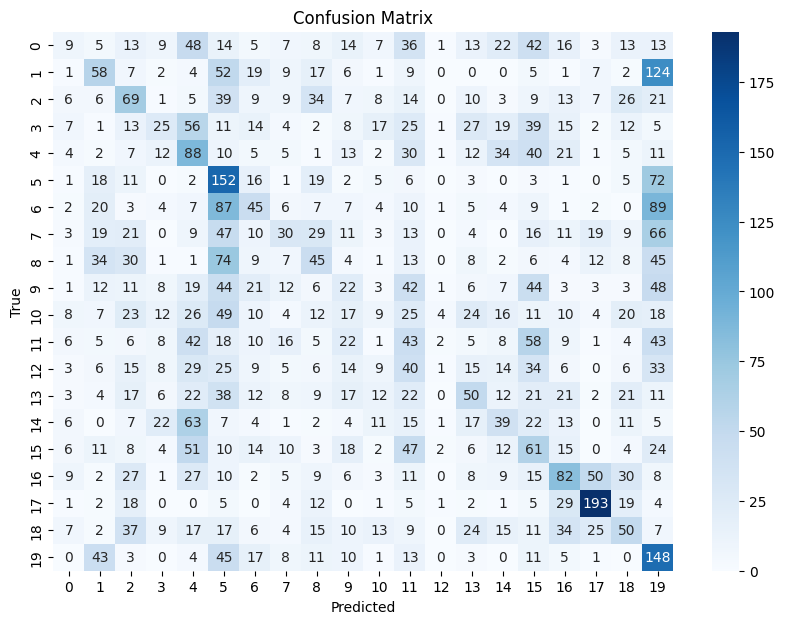

Accuracy for class 0 (feet): 3.02%
Accuracy for class 1 (duck): 17.90%
Accuracy for class 2 (face): 23.31%
Accuracy for class 3 (finger): 8.25%
Accuracy for class 4 (dog): 28.95%
Accuracy for class 5 (flower): 47.95%
Accuracy for class 6 (food): 14.38%
Accuracy for class 7 (drink): 9.38%
Accuracy for class 8 (elephant): 14.75%
Accuracy for class 9 (eye): 6.96%
Accuracy for class 10 (all): 2.91%
Accuracy for class 11 (cry): 13.78%
Accuracy for class 12 (after): 0.36%
Accuracy for class 13 (callonphone): 16.23%
Accuracy for class 14 (dance): 15.60%
Accuracy for class 15 (TV): 19.81%
Accuracy for class 16 (airplane): 26.11%
Accuracy for class 17 (dad): 63.91%
Accuracy for class 18 (alligator): 16.03%
Accuracy for class 19 (bird): 45.82%

Classification Report:

              precision    recall  f1-score   support

        feet       0.11      0.03      0.05       298
        duck       0.23      0.18      0.20       324
        face       0.20      0.23      0.21       296
      finger  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Convert lists to numpy arrays for compatibility with sklearn
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Ensure the class names are in the correct order for target_names
ordered_class_names = [name for name, num in sorted((dataset.sign_to_label()).items(), key=lambda item: item[1])]

# Per-Class Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    class_name = ordered_class_names[i]
    print(f"Accuracy for class {i} ({class_name}): {acc*100:.2f}%")

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=1))

In [ ]:
from sklearn.metrics import classification_report

def print_top_misclassified_classes(y_true, y_pred, sign_to_label, N=3, zero_division=1):
    """
    Prints the top N classes that get misclassified the most.

    Parameters:
    - y_true: Actual labels
    - y_pred: Predicted labels by the model
    - sign_to_label: Dictionary mapping class names to class numbers
    - N: Number of top misclassified classes to print
    - zero_division: Parameter for handling zero division in classification_report

    Returns:
    None
    """

    # Ensure the class names are in the correct order for target_names
    ordered_class_names = [name for name, num in sorted(sign_to_label.items(), key=lambda item: item[1])]

    # Generate and print classification report with class names
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=zero_division))

    # Generate classification report as dict to find misclassified classes
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=zero_division)

    # Create a dictionary to store misclassification rates
    misclassification_rates = {}

    # Iterate through each class in the report
    for class_num, metrics in report.items():
        if class_num.isdigit():
            class_name = [key for key, value in sign_to_label.items() if value == int(class_num)][0]
            misclassification_rates[class_name] = 1 - metrics['recall']

    # Sort classes based on misclassification rate
    sorted_classes = sorted(misclassification_rates, key=misclassification_rates.get, reverse=True)

    # Print top N misclassified classes
    print(f"\nTop {N} misclassified classes:")
    for i in range(N):
        class_name = sorted_classes[i]
        print(f"{i+1}. {class_name} - Misclassification rate: {misclassification_rates[class_name]:.2f}")

In [ ]:
print_top_misclassified_classes(y_true, y_pred, dataset.sign_to_label(), N=10, zero_division=1)


Classification Report:

              precision    recall  f1-score   support

        feet       0.11      0.03      0.05       298
        duck       0.23      0.18      0.20       324
        face       0.20      0.23      0.21       296
      finger       0.19      0.08      0.11       303
         dog       0.17      0.29      0.21       304
      flower       0.20      0.48      0.28       317
        food       0.19      0.14      0.16       313
       drink       0.19      0.09      0.13       320
    elephant       0.18      0.15      0.16       305
         eye       0.10      0.07      0.08       316
         all       0.08      0.03      0.04       309
         cry       0.10      0.14      0.12       312
       after       0.06      0.00      0.01       278
 callonphone       0.21      0.16      0.18       308
       dance       0.18      0.16      0.17       250
          TV       0.13      0.20      0.16       308
    airplane       0.26      0.26      0.26       314
  